11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting GAN training...
Epoch 1/25 - Gen Loss: 0.6958, Disc Loss: 1.1067
Epoch 2/25 - Gen Loss: 0.7586, Disc Loss: 1.3359
Epoch 3/25 - Gen Loss: 0.8563, Disc Loss: 1.2118
Epoch 4/25 - Gen Loss: 0.7643, Disc Loss: 1.3546
Epoch 5/25 - Gen Loss: 0.8263, Disc Loss: 1.2799


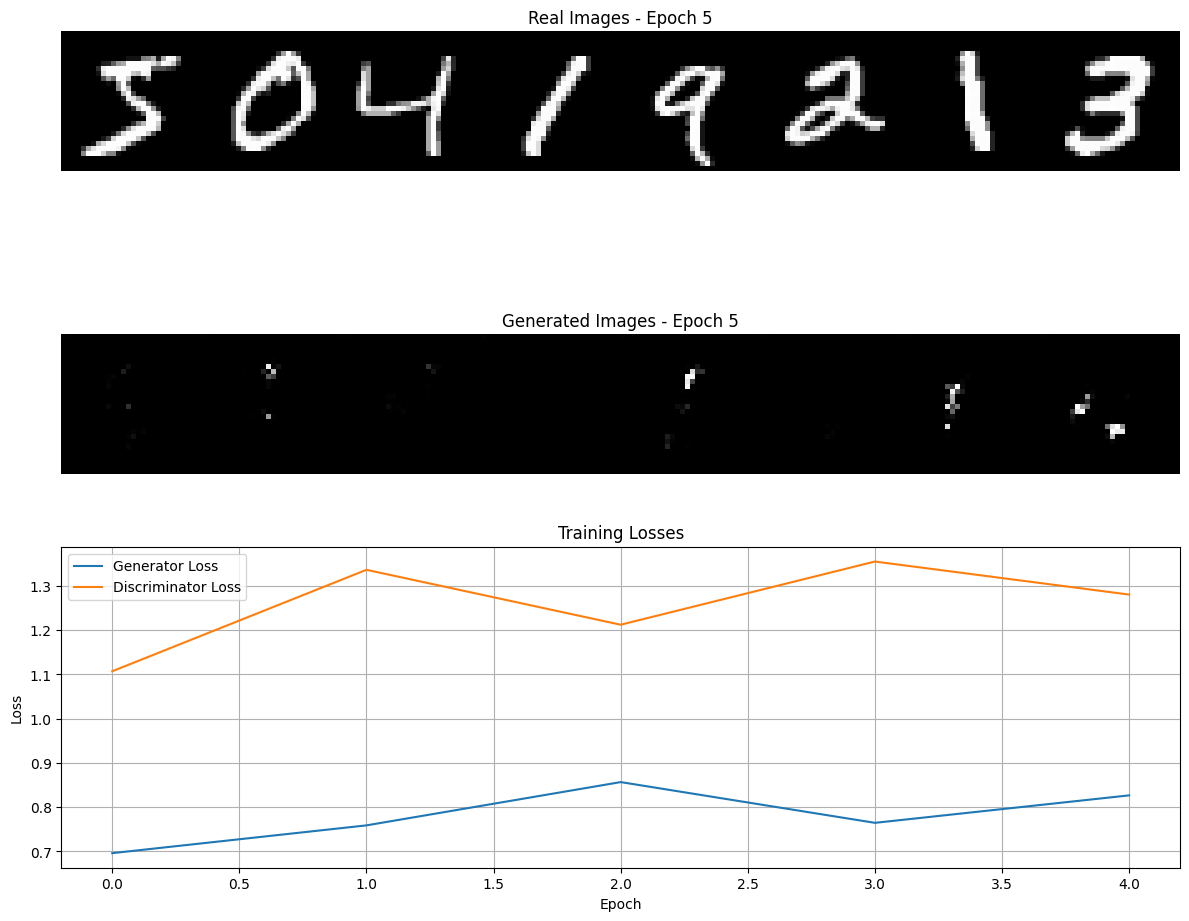

Epoch 6/25 - Gen Loss: 0.8591, Disc Loss: 1.2624
Epoch 7/25 - Gen Loss: 0.8101, Disc Loss: 1.2962
Epoch 8/25 - Gen Loss: 0.9218, Disc Loss: 1.2238
Epoch 9/25 - Gen Loss: 0.8362, Disc Loss: 1.3023
Epoch 10/25 - Gen Loss: 0.9230, Disc Loss: 1.2429


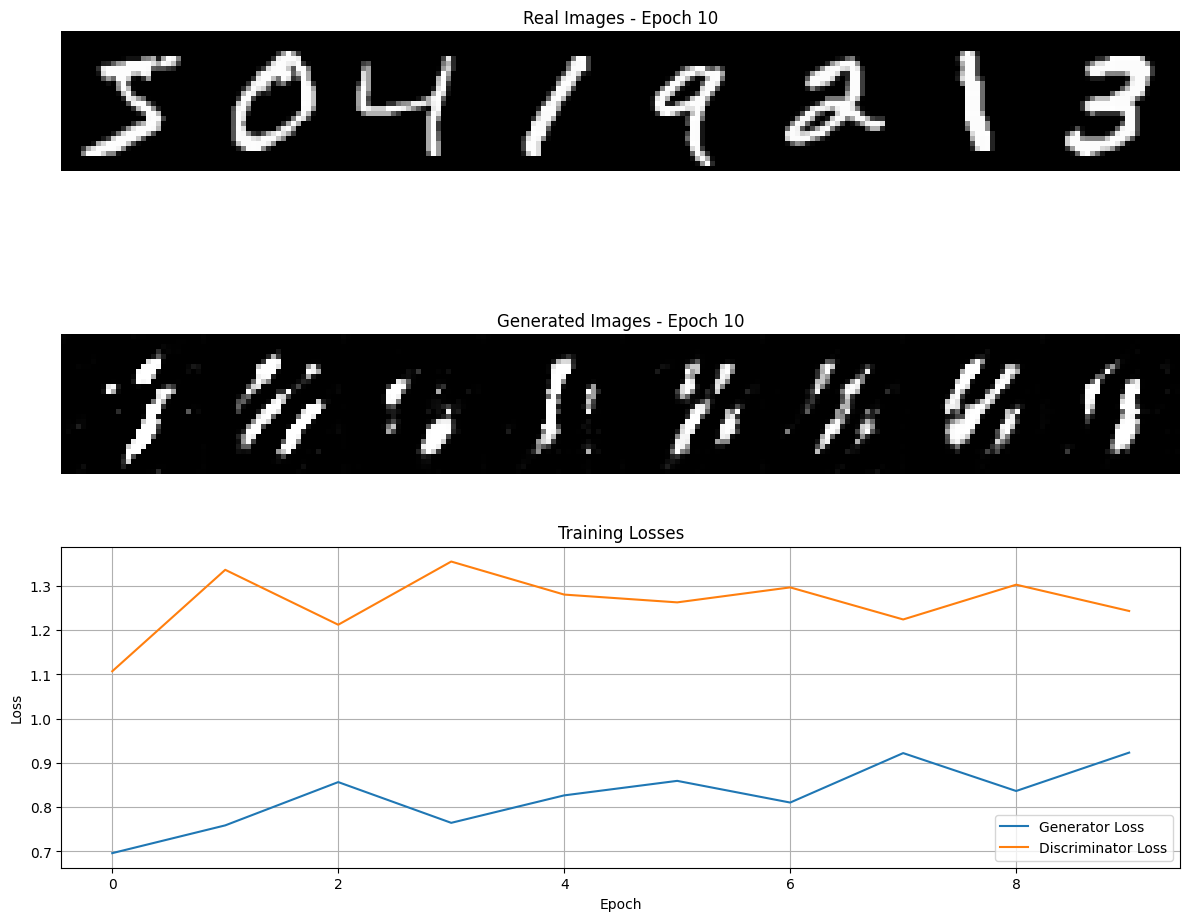

Epoch 11/25 - Gen Loss: 0.8660, Disc Loss: 1.2681
Epoch 12/25 - Gen Loss: 0.9531, Disc Loss: 1.1960
Epoch 13/25 - Gen Loss: 0.9611, Disc Loss: 1.1667
Epoch 14/25 - Gen Loss: 1.0193, Disc Loss: 1.1393
Epoch 15/25 - Gen Loss: 0.9984, Disc Loss: 1.1792


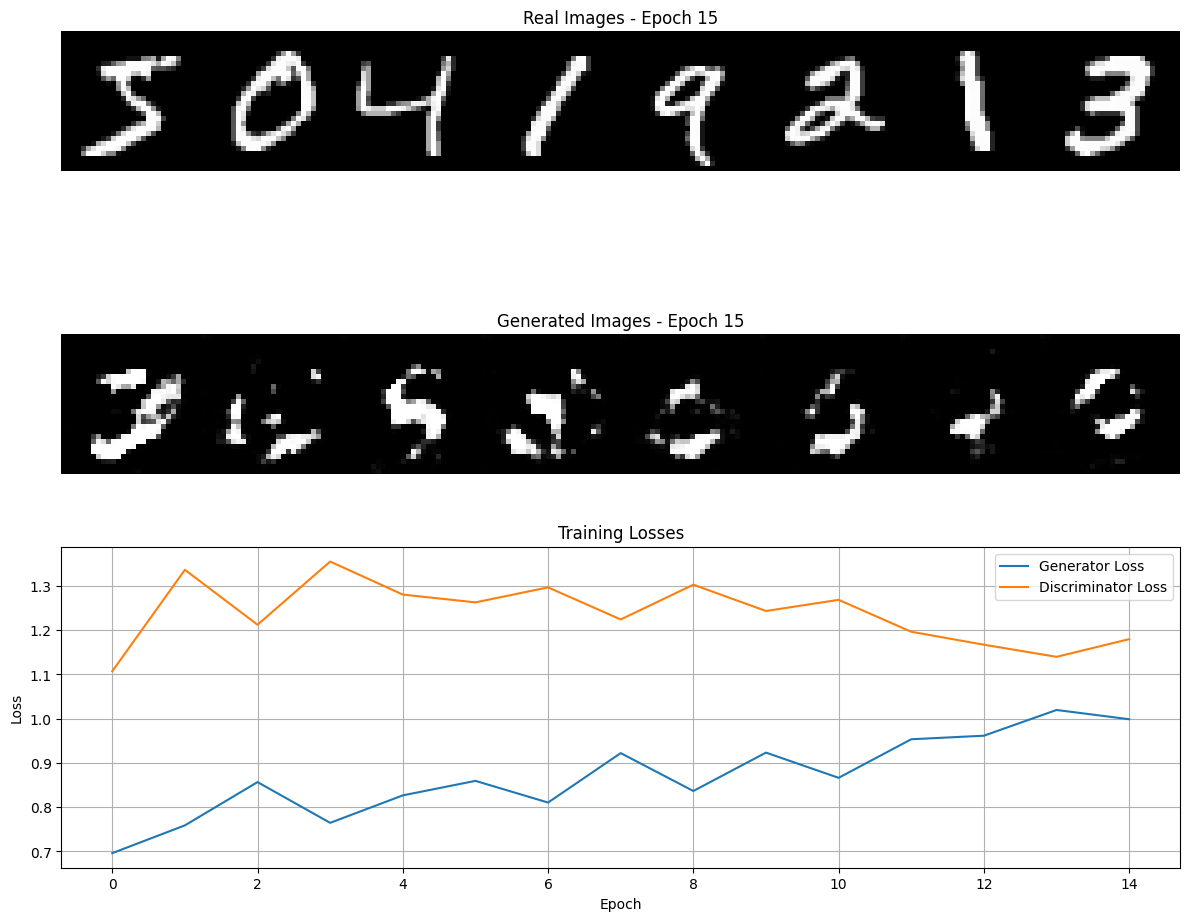

Epoch 16/25 - Gen Loss: 1.0755, Disc Loss: 1.1167
Epoch 17/25 - Gen Loss: 1.0597, Disc Loss: 1.1227
Epoch 18/25 - Gen Loss: 1.1773, Disc Loss: 1.0173
Epoch 19/25 - Gen Loss: 1.2017, Disc Loss: 1.0617
Epoch 20/25 - Gen Loss: 1.2611, Disc Loss: 1.0315


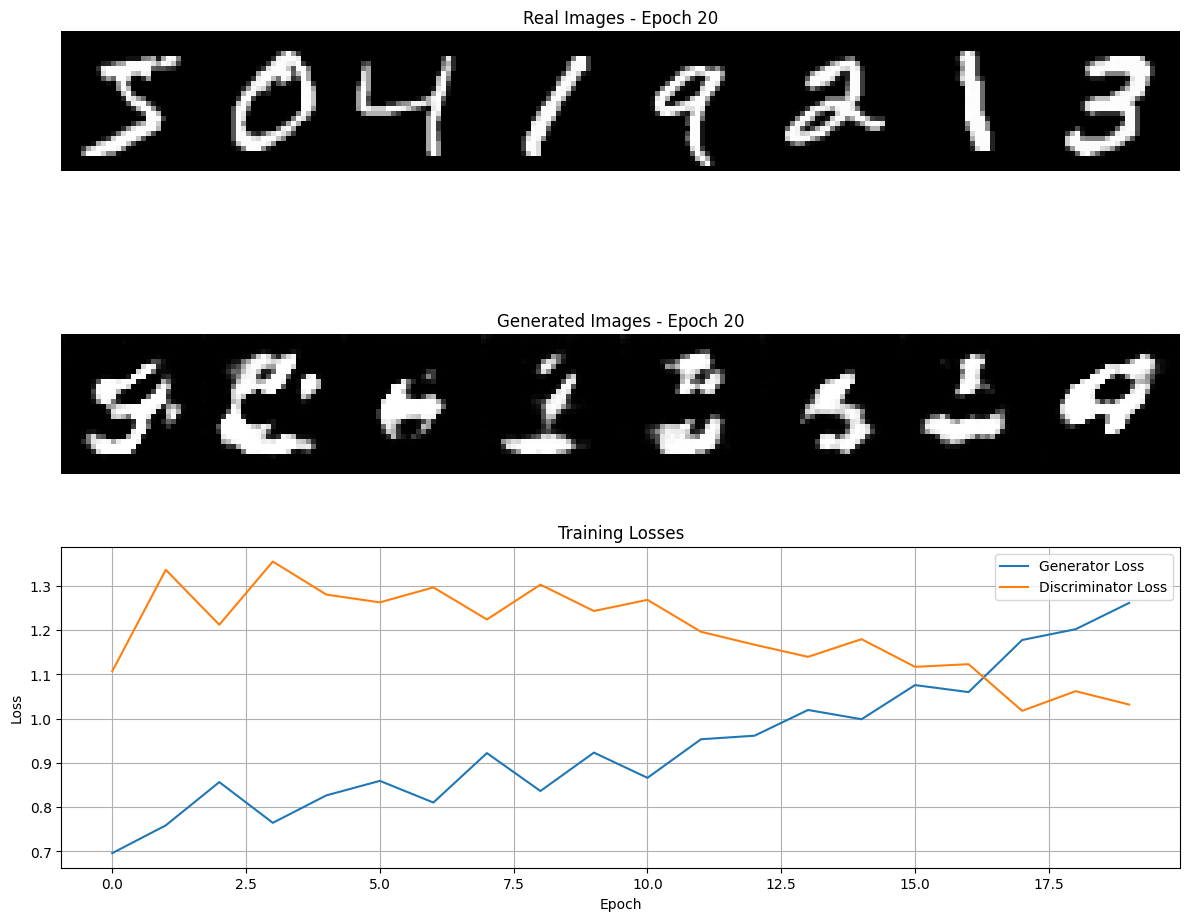

Epoch 21/25 - Gen Loss: 1.2386, Disc Loss: 1.0215
Epoch 22/25 - Gen Loss: 1.1872, Disc Loss: 1.0719
Epoch 23/25 - Gen Loss: 1.3571, Disc Loss: 0.9330
Epoch 24/25 - Gen Loss: 1.3180, Disc Loss: 0.9730
Epoch 25/25 - Gen Loss: 1.2961, Disc Loss: 1.0073


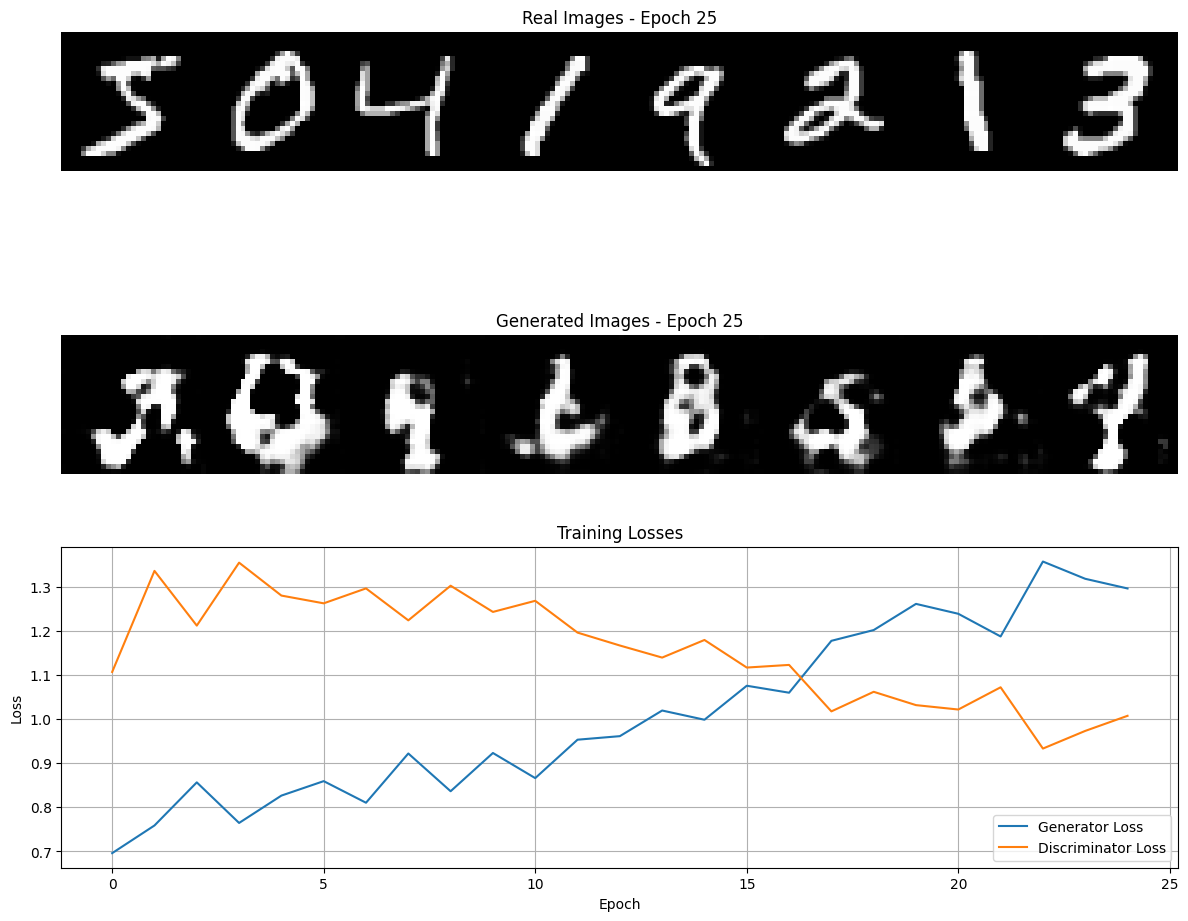

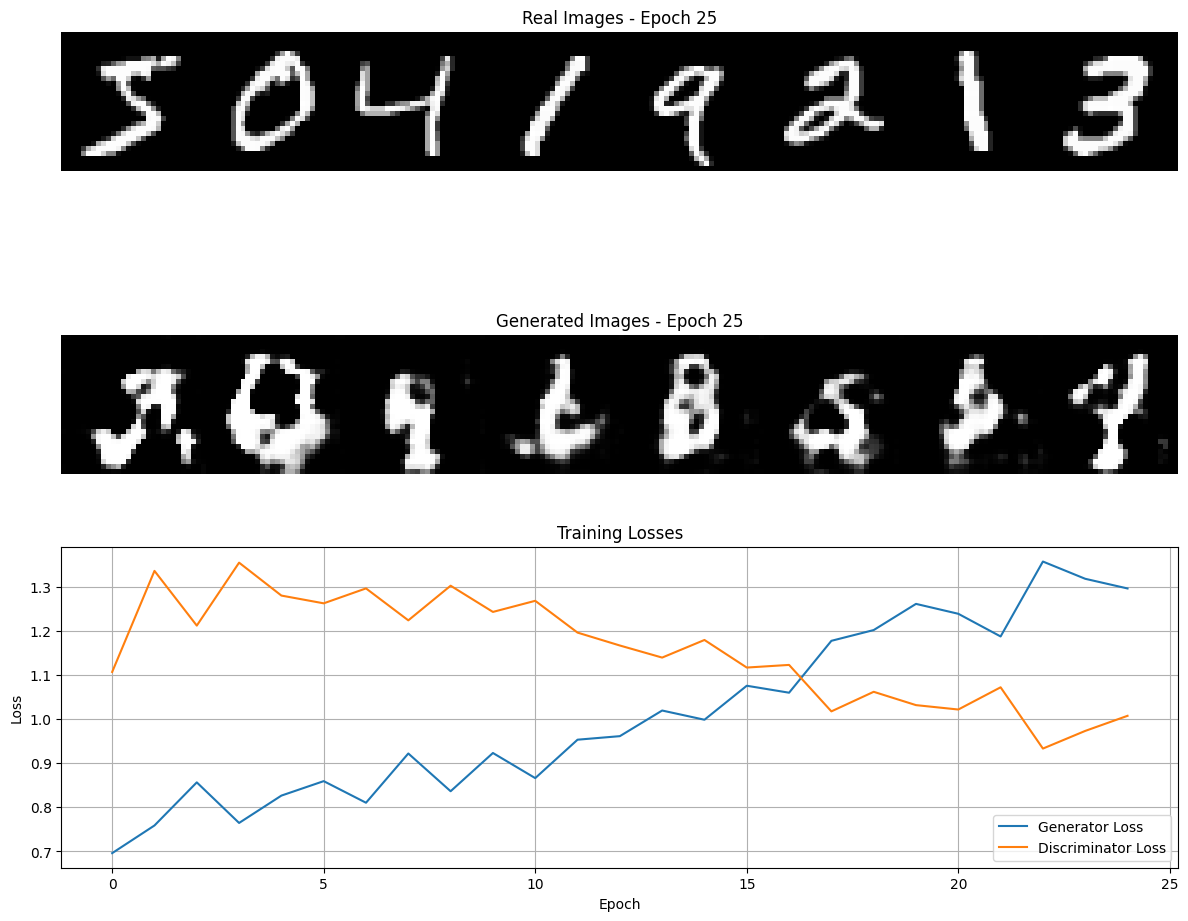

In [1]:


import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

# Parameters
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 25
noise_dim = 100
num_examples_to_generate = 16

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Initialize models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Generate and save images for visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Lists to store losses
gen_losses = []
disc_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        epoch_gen_loss = []
        epoch_disc_loss = []

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            epoch_gen_loss.append(g_loss)
            epoch_disc_loss.append(d_loss)

        # Calculate average loss for the epoch
        avg_gen_loss = np.mean(epoch_gen_loss)
        avg_disc_loss = np.mean(epoch_disc_loss)
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        print(f'Epoch {epoch + 1}/{epochs} - Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}')

        # Generate images every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            generate_and_plot_images(generator, epoch + 1, seed)

def generate_and_plot_images(model, epoch, test_input):
    # Generate images
    predictions = model(test_input, training=False)

    # Create figure with subplots
    fig = plt.figure(figsize=(12, 10))

    # Plot real images
    plt.subplot(3, 1, 1)
    real_images = train_images[:8]
    real_images = real_images.reshape(8, 28, 28)
    combined_real = np.hstack([real_images[i] for i in range(8)])
    plt.imshow(combined_real, cmap='gray')
    plt.title(f"Real Images - Epoch {epoch}")
    plt.axis('off')

    # Plot fake/generated images
    plt.subplot(3, 1, 2)
    generated_images = predictions.numpy()
    generated_images = generated_images.reshape(num_examples_to_generate, 28, 28)
    combined_fake = np.hstack([generated_images[i] for i in range(8)])
    plt.imshow(combined_fake, cmap='gray')
    plt.title(f"Generated Images - Epoch {epoch}")
    plt.axis('off')

    # Plot losses
    plt.subplot(3, 1, 3)
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Start training
print("Starting GAN training...")
train(train_dataset, EPOCHS)

# Generate final images and losses
generate_and_plot_images(generator, EPOCHS, seed)